# ResNet Ablation Study

[Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)에서 제공하는 cats vs dogs 데이터셋을 활용해 ResNet Ablation Study 진행하고자 한다.

## .1 Cats n Dogs 데이터 준비

In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model #모델 시각화
import pickle

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

`tensorflow_addons` 안될경우

`!pip install tensorflow-addons`로 모듈을 설치하길 바란다.

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete2SGMZX/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [6]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
ds_info.features["label"].num_classes
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

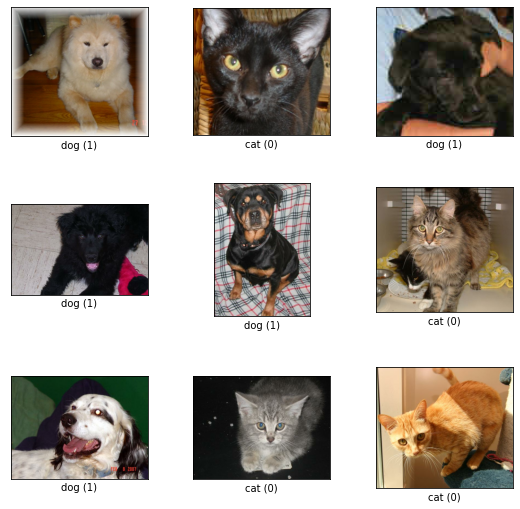

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

데이터를 잘 불러온것을 확인할 수 있다.

## 2. ResNet 기본 블록 구성하기


**ResNet-34**와 **ResNet-50** 구현

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

### Conv 블록 설계

CNN-BN-Activation

In [9]:
# function for building Conv Block

def build_conv_block(input_layer,
                    channel=64,
                    kernel_size = 3,
                    strides = 1,
                    stage_num=1,
                    unit_num=1,
                    block_num=1,
                    activation='relu'
                   ):
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    x = keras.layers.Conv2D(filters=channel,kernel_size = kernel_size, strides=strides ,padding='same',
                            name=f'stage{stage_num}_{unit_num}_conv{block_num}')(x)    

    # Batch Normal 레이어
    x = keras.layers.BatchNormalization(name = f'stage{stage_num}_{unit_num}_bn{block_num}', momentum=0.9)(x)
    
    #activation 레이어
    if activation :
        x = keras.layers.Activation(activation = activation, name = f'stage{stage_num}_{unit_num}_relu{block_num}')(x)

    return x

In [10]:
conv_input_layer = keras.layers.Input(shape=(32,32,3))
conv_block_output = build_conv_block(conv_input_layer) 

Conv 블록 확인

In [11]:
model = keras.Model(inputs=conv_input_layer, outputs=conv_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stage1_1_conv1 (Conv2D)     (None, 32, 32, 64)        1792      
                                                                 
 stage1_1_bn1 (BatchNormaliz  (None, 32, 32, 64)       256       
 ation)                                                          
                                                                 
 stage1_1_relu1 (Activation)  (None, 32, 32, 64)       0         
                                                                 
Total params: 2,048
Trainable params: 1,920
Non-trainable params: 128
_________________________________________________________________


### Residual 블록 설계

In [12]:
# function for building Conv Block

def build_residual_block(input_layer,
                    channel=64,
                    stage_num=1,
                    unit_num=1,
                    is_50 = True,
                    is_first = 0):
    # 입력 레이어
    x = input_layer
    
    #ResNet 50
    if is_50 :
        for unit in range(1,unit_num+1):
            if unit == 1 and is_first == 0: 
                short_cut = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides=1, 
                                                name=f'stage{stage_num}_{unit}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                        
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                short_cut = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides=2, 
                                                name=f'stage{stage_num}_{unit}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
            else :
                short_cut = x
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                
            x = keras.layers.Add()([x, short_cut])
            x = keras.layers.Activation('relu')(x)
    
    #ResNet 34
    else :
        for unit in range(1,unit_num+1):
            
            if unit == 1 and is_first == 0:
                short_cut = keras.layers.Conv2D(filters=channel, kernel_size=1, strides=1, 
                                                name=f'stage{stage_num}_{unit_num}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                short_cut = keras.layers.Conv2D(filters=channel, kernel_size=1, strides=2, 
                                                name=f'stage{stage_num}_{unit_num}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
            else :
                short_cut = x
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            x = keras.layers.Add()([x, short_cut])
            x = keras.layers.Activation('relu')(x)
            
    return x

In [13]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              unit_num_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              activation = 'softmax',
              is_50 = True,
              name = 'ResNet50'):
    
    assert len(unit_num_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    x = build_conv_block(input_layer=input_layer,channel=64,kernel_size=7,strides=2)
    x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same',name = 'stage1_1_maxpooling')(x)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (unit_num, channel) in enumerate(zip(unit_num_list, channel_list)):
        
        stage = i+2
        x = build_residual_block(x,channel,stage,unit_num,is_50,i) 
        
    x = keras.layers.GlobalAvgPool2D()(x)
    output = keras.layers.Dense(units=num_classes, activation=activation)(x)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output,
        name=name
    )
    return model

### ResNet-50

In [14]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
resnet_50 = build_resnet(is_50=True, num_classes = 10, name="ResNet50")

resnet_50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage1_1_conv1 (Conv2D)        (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 stage1_1_bn1 (BatchNormalizati  (None, 16, 16, 64)  256         ['stage1_1_conv1[0][0]']         
 on)                                                                                              
                                                                                                  
 stage1_1_relu1 (Activation)    (None, 16, 16, 64)   0           ['stage1_1_bn1[0][0]']    

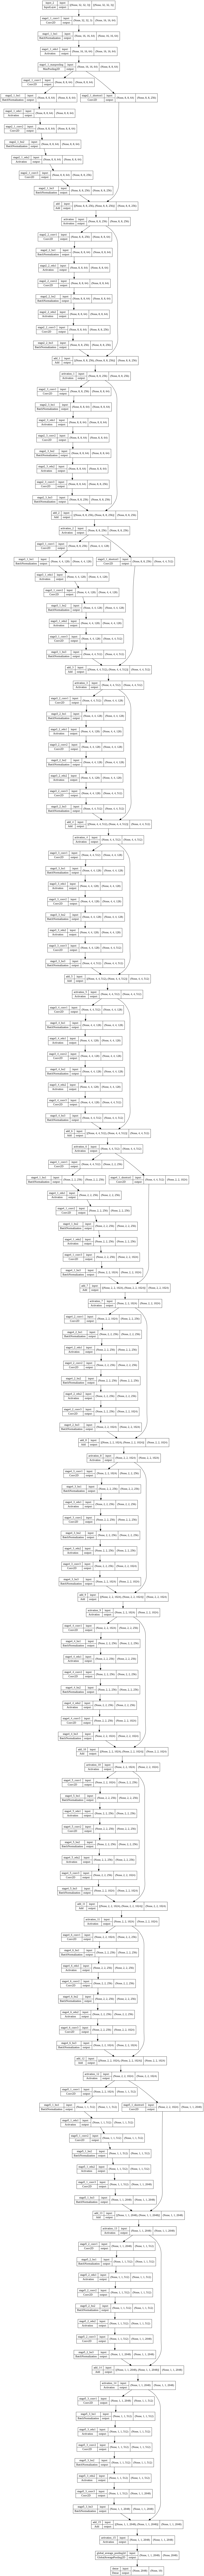

In [15]:
plot_model(resnet_50, show_shapes=True)

### ResNet-34

In [16]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
resnet_34 = build_resnet(is_50=False, num_classes = 10, name="ResNet34")

resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage1_1_conv1 (Conv2D)        (None, 16, 16, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 stage1_1_bn1 (BatchNormalizati  (None, 16, 16, 64)  256         ['stage1_1_conv1[0][0]']         
 on)                                                                                              
                                                                                                  
 stage1_1_relu1 (Activation)    (None, 16, 16, 64)   0           ['stage1_1_bn1[0][0]']    

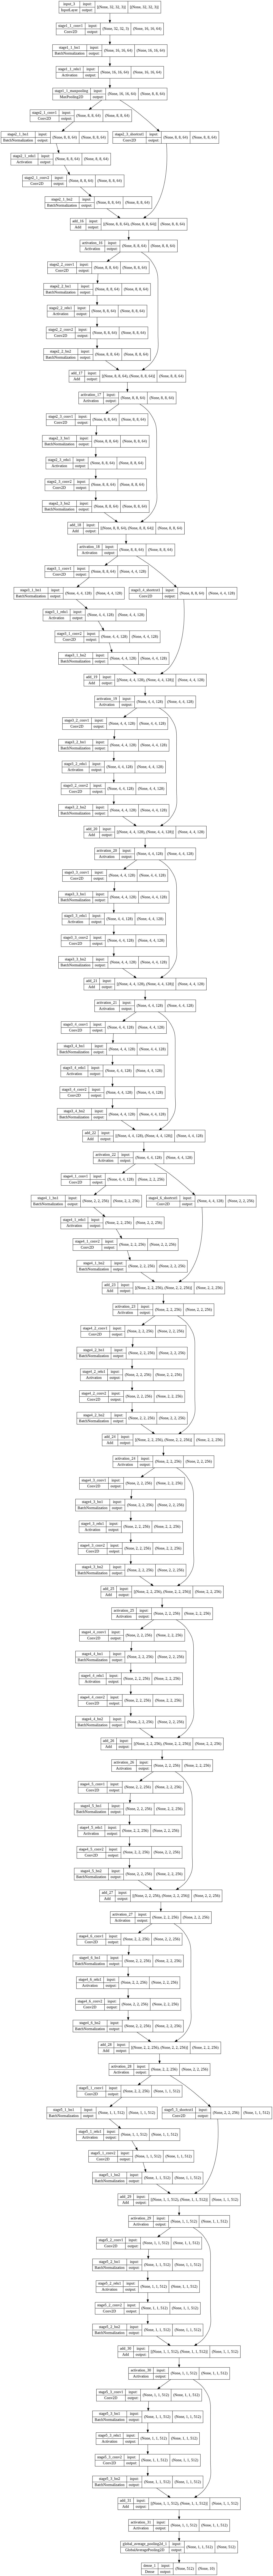

In [17]:
plot_model(resnet_34, show_shapes=True)

### Plain ResNet

In [19]:
# function for building Conv Block

def build_conv_block(input_layer,
                    channel=64,
                    kernel_size = 3,
                    strides = 1,
                    stage_num=1,
                    unit_num=1,
                    block_num=1,
                    activation='relu'
                   ):
    # 입력 레이어
    x = input_layer
    
    
    # CNN 레이어
    x = keras.layers.Conv2D(filters=channel,kernel_size = kernel_size, strides=strides ,padding='same',
                            name=f'stage{stage_num}_{unit_num}_conv{block_num}')(x)    

    # Batch Normal 레이어
    x = keras.layers.BatchNormalization(name = f'stage{stage_num}_{unit_num}_bn{block_num}', momentum=0.9)(x)
    
    #activation 레이어
    if activation :
        x = keras.layers.Activation(activation = activation, name = f'stage{stage_num}_{unit_num}_relu{block_num}')(x)

    return x

In [20]:
# function for building Conv Block

def build_plain_block(input_layer,
                    channel=64,
                    stage_num=1,
                    unit_num=1,
                    is_50 = True,
                    is_first = 0):
    # 입력 레이어
    x = input_layer
    
    #ResNet 50
    if is_50 :
        for unit in range(1,unit_num+1):
            if unit == 1 and is_first == 0: 
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                        
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
            else :
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                
            x = keras.layers.Activation('relu')(x)
    
    #ResNet 34
    else :
        for unit in range(1,unit_num+1):
            
            if unit == 1 and is_first == 0: 
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
            else :
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            x = keras.layers.Activation('relu')(x)
            
    return x

In [21]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_plain_resnet(input_shape=(32,32,3),
              unit_num_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50 = True,
              activation = 'softmax',
              name = 'ResNet50'):
    
    assert len(unit_num_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    x = build_conv_block(input_layer=input_layer,channel=64,kernel_size=7,strides=2)
    x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same',name = 'stage1_1_maxpooling')(x)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (unit_num, channel) in enumerate(zip(unit_num_list, channel_list)):
        
        stage = i+2
        x = build_plain_block(x,channel,stage,unit_num,is_50,i) 
        
    x = keras.layers.GlobalAvgPool2D()(x)
    output = keras.layers.Dense(units=num_classes, activation=activation)(x)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output,
        name=name
    )
    return model

### Plain ResNet-50

In [22]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
plain_resnet_50 = build_plain_resnet(is_50=True, num_classes = 10, name="Plain-ResNet50")

plain_resnet_50.summary()

Model: "Plain-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stage1_1_conv1 (Conv2D)     (None, 16, 16, 64)        9472      
                                                                 
 stage1_1_bn1 (BatchNormaliz  (None, 16, 16, 64)       256       
 ation)                                                          
                                                                 
 stage1_1_relu1 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 stage1_1_maxpooling (MaxPoo  (None, 8, 8, 64)         0         
 ling2D)                                                         
                                                                 
 stage2_1_conv1 (Conv2D)     (None, 8, 8, 64)       

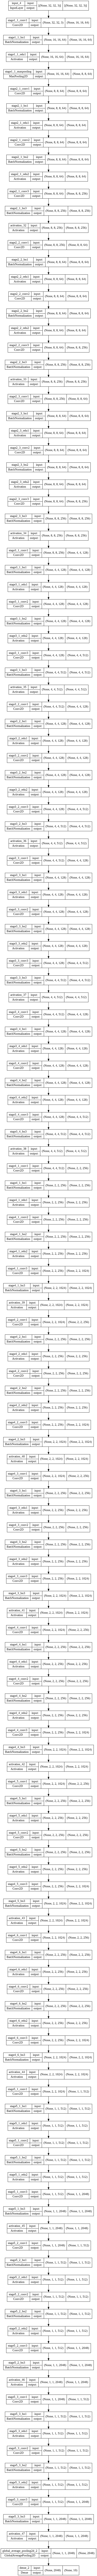

In [23]:
plot_model(plain_resnet_50, show_shapes=True)

### Plain ResNet-34

In [25]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
plain_resnet_34 = build_plain_resnet(is_50=False, num_classes = 10, name="Plain-ResNet50")

plain_resnet_34.summary()

Model: "Plain-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stage1_1_conv1 (Conv2D)     (None, 16, 16, 64)        9472      
                                                                 
 stage1_1_bn1 (BatchNormaliz  (None, 16, 16, 64)       256       
 ation)                                                          
                                                                 
 stage1_1_relu1 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 stage1_1_maxpooling (MaxPoo  (None, 8, 8, 64)         0         
 ling2D)                                                         
                                                                 
 stage2_1_conv1 (Conv2D)     (None, 8, 8, 64)       

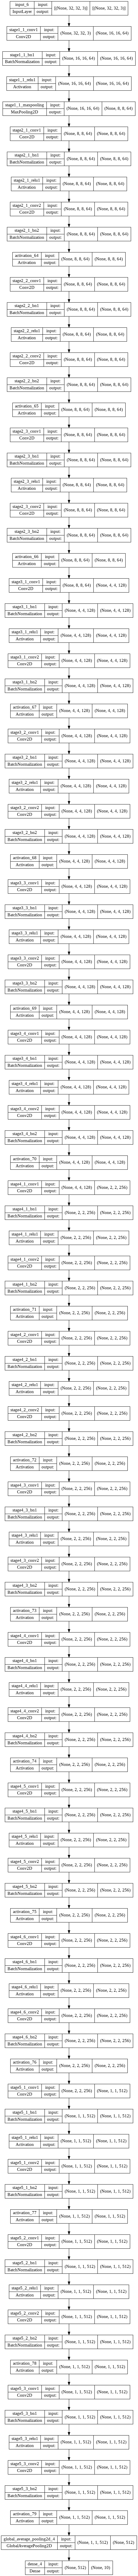

In [26]:
plot_model(plain_resnet_34, show_shapes=True)

## 3. 모델 학습

Plain, Residual 비교

In [34]:
BATCH_SIZE = 64
EPOCH = 20

In [28]:
def normalize_and_resize_img(image, label): #map에 사용될 함수
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [29]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1 #interleaving
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [30]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE) #normalization 진행
ds_test = apply_normalize_on_dataset(ds_test,is_test=True, batch_size=BATCH_SIZE)

### 학습 환경 설정

optimizer SGD

In [31]:
resnet_50 = build_resnet(input_shape=(224,224,3), is_50=True,num_classes = 1, activation='sigmoid', name="ResNet50")
resnet_34 = build_resnet(input_shape=(224,224,3), is_50=False,num_classes = 1, activation='sigmoid', name="ResNet34")
plain_resnet_50 = build_plain_resnet(input_shape=(224,224,3), is_50=True,num_classes = 1, activation='sigmoid', name="Plain-ResNet50")
plain_resnet_34 = build_plain_resnet(input_shape=(224,224,3), is_50=False,num_classes = 1, activation='sigmoid', name="Plain-ResNet34")

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=2e-4, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=2e-4, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

plain_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=2e-4, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

plain_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=2e-4, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


optimizer Adam

In [32]:
resnet_50 = build_resnet(input_shape=(224,224,3),is_50=True,num_classes = 1,activation='sigmoid',name="ResNet50")
resnet_34 = build_resnet(input_shape=(224,224,3),is_50=False,num_classes = 1,activation='sigmoid',name="ResNet34")
plain_resnet_50 = build_plain_resnet(input_shape=(224,224,3),is_50=True,num_classes = 1,activation='sigmoid',name="Plain-ResNet50")
plain_resnet_34 = build_plain_resnet(input_shape=(224,224,3),is_50=False,num_classes = 1,activation='sigmoid',name="Plain-ResNet34")

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=2e-4, name='Adam'),
    metrics=['accuracy'],
)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=2e-4, name='Adam'),
    metrics=['accuracy'],
)

plain_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=2e-4, name='Adam'),
    metrics=['accuracy'],
)

plain_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=2e-4, name='Adam'),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 학습

In [35]:
history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 106s 314ms/step - loss: 0.5564 - accuracy: 0.7185 - val_loss: 0.5145 - val_accuracy: 0.7431
Epoch 2/20
290/290 [==============================] - 91s 314ms/step - loss: 0.4555 - accuracy: 0.7857 - val_loss: 0.5023 - val_accuracy: 0.7635
Epoch 3/20
290/290 [==============================] - 91s 314ms/step - loss: 0.3827 - accuracy: 0.8273 - val_loss: 0.5526 - val_accuracy: 0.7569
Epoch 4/20
290/290 [==============================] - 91s 314ms/step - loss: 0.3019 - accuracy: 0.8692 - val_loss: 0.4402 - val_accuracy: 0.8166
Epoch 5/20
290/290 [==============================] - 91s 314ms/step - loss: 0.2485 - accuracy: 0.8954 - val_loss: 0.9101 - val_accuracy: 0.7220
Epoch 6/20
290/290 [==============================] - 91s 314ms/step - loss: 0.2138 - accuracy: 0.9143 - val_loss: 0.3943 - val_accuracy: 0.8338
Epoch 7/20
290/290 [==============================] - 95s 327ms/step - loss: 0.1643 - accuracy: 0.9314 - val_loss: 0.5364 - val_a

In [38]:
history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 72s 195ms/step - loss: 0.5904 - accuracy: 0.6916 - val_loss: 0.5566 - val_accuracy: 0.7287
Epoch 2/20
290/290 [==============================] - 56s 191ms/step - loss: 0.3930 - accuracy: 0.8202 - val_loss: 0.4834 - val_accuracy: 0.7650
Epoch 3/20
290/290 [==============================] - 55s 190ms/step - loss: 0.2952 - accuracy: 0.8691 - val_loss: 0.3253 - val_accuracy: 0.8559
Epoch 4/20
290/290 [==============================] - 55s 190ms/step - loss: 0.2026 - accuracy: 0.9156 - val_loss: 0.4017 - val_accuracy: 0.8403
Epoch 5/20
290/290 [==============================] - 55s 191ms/step - loss: 0.1654 - accuracy: 0.9331 - val_loss: 0.2722 - val_accuracy: 0.8852
Epoch 6/20
290/290 [==============================] - 55s 191ms/step - loss: 0.1344 - accuracy: 0.9459 - val_loss: 0.2284 - val_accuracy: 0.9036
Epoch 7/20
290/290 [==============================] - 55s 191ms/step - loss: 0.1016 - accuracy: 0.9604 - val_loss: 0.2472 - val_ac

In [39]:
history_50_plain = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 117s 272ms/step - loss: 0.6934 - accuracy: 0.5571 - val_loss: 0.6809 - val_accuracy: 0.5753
Epoch 2/20
290/290 [==============================] - 78s 269ms/step - loss: 0.6463 - accuracy: 0.6260 - val_loss: 0.6740 - val_accuracy: 0.6452
Epoch 3/20
290/290 [==============================] - 78s 270ms/step - loss: 0.6076 - accuracy: 0.6703 - val_loss: 0.6094 - val_accuracy: 0.6749
Epoch 4/20
290/290 [==============================] - 78s 270ms/step - loss: 0.5770 - accuracy: 0.7018 - val_loss: 0.5765 - val_accuracy: 0.7112
Epoch 5/20
290/290 [==============================] - 83s 287ms/step - loss: 0.5454 - accuracy: 0.7223 - val_loss: 0.6647 - val_accuracy: 0.7049
Epoch 6/20
290/290 [==============================] - 79s 271ms/step - loss: 0.5160 - accuracy: 0.7471 - val_loss: 0.5663 - val_accuracy: 0.7255
Epoch 7/20
290/290 [==============================] - 79s 271ms/step - loss: 0.4876 - accuracy: 0.7625 - val_loss: 0.5635 - val_a

In [40]:
history_34_plain = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 68s 183ms/step - loss: 0.6627 - accuracy: 0.6046 - val_loss: 0.6219 - val_accuracy: 0.6454
Epoch 2/20
290/290 [==============================] - 53s 181ms/step - loss: 0.5713 - accuracy: 0.7011 - val_loss: 0.5934 - val_accuracy: 0.7142
Epoch 3/20
290/290 [==============================] - 53s 181ms/step - loss: 0.4762 - accuracy: 0.7714 - val_loss: 0.5834 - val_accuracy: 0.7114
Epoch 4/20
290/290 [==============================] - 53s 182ms/step - loss: 0.3834 - accuracy: 0.8290 - val_loss: 0.4856 - val_accuracy: 0.7958
Epoch 5/20
290/290 [==============================] - 53s 182ms/step - loss: 0.2970 - accuracy: 0.8725 - val_loss: 0.3946 - val_accuracy: 0.8251
Epoch 6/20
290/290 [==============================] - 53s 182ms/step - loss: 0.2536 - accuracy: 0.8933 - val_loss: 0.2912 - val_accuracy: 0.8728
Epoch 7/20
290/290 [==============================] - 53s 183ms/step - loss: 0.2169 - accuracy: 0.9097 - val_loss: 0.2694 - val_ac

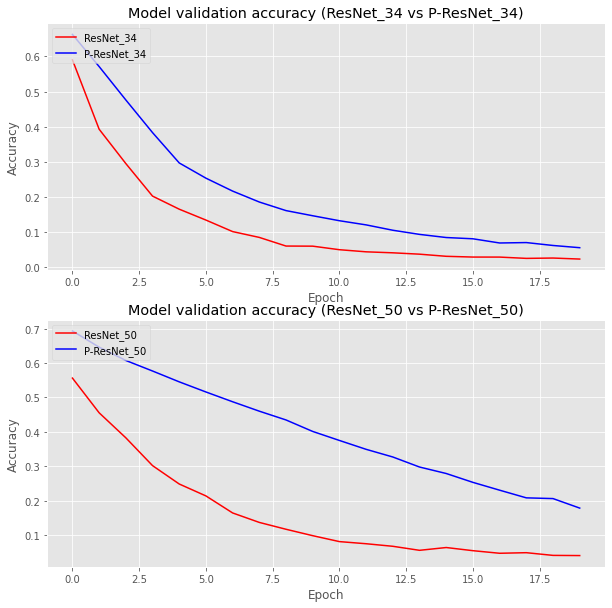

In [48]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model validation accuracy (ResNet_34 vs P-ResNet_34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34', 'P-ResNet_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model validation accuracy (ResNet_50 vs P-ResNet_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_50', 'P-ResNet_50'], loc='upper left')
plt.show()

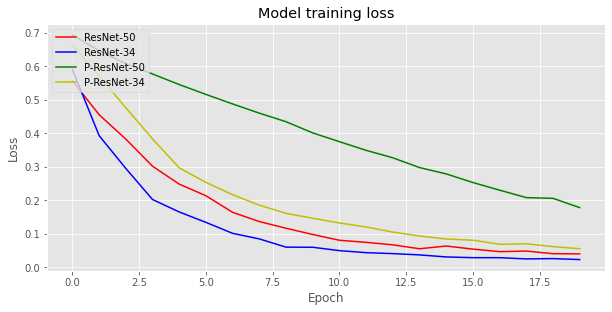

In [49]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_34.history['loss'], 'b')
plt.plot(history_50_plain.history['loss'], 'g')
plt.plot(history_34_plain.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'ResNet-34','P-ResNet-50','P-ResNet-34'], loc='upper left')
plt.show()

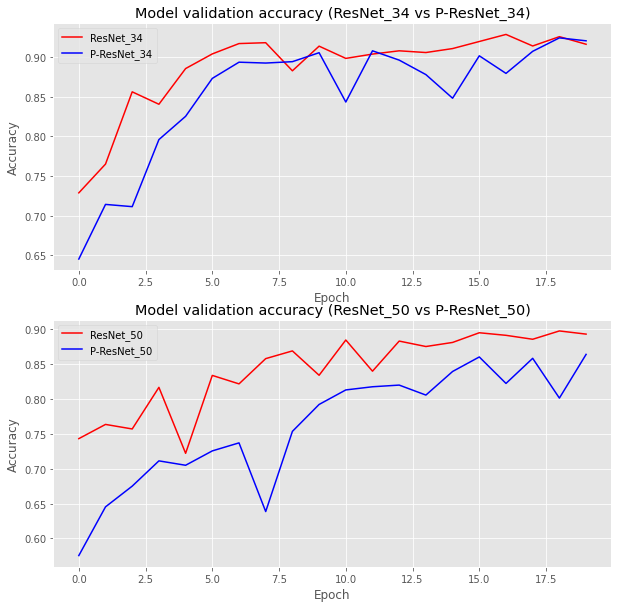

In [50]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (ResNet_34 vs P-ResNet_34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34', 'P-ResNet_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (ResNet_50 vs P-ResNet_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_50', 'P-ResNet_50'], loc='upper left')
plt.show()

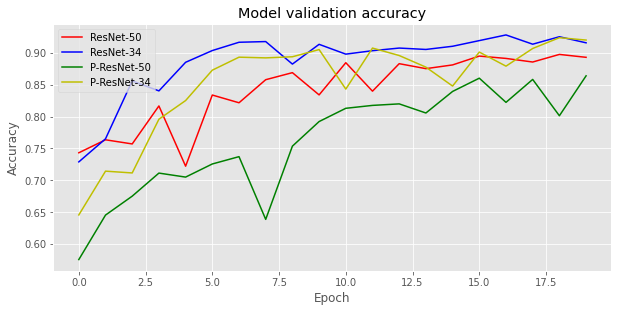

In [52]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50_plain.history['val_accuracy'], 'g')
plt.plot(history_34_plain.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'ResNet-34','P-ResNet-50','P-ResNet-34'], loc='upper left')
plt.show()

In [55]:
resnet_loss_34 = np.array(history_34.history['loss'])
resnet_loss_50 = np.array(history_50.history['loss'])
presnet_loss_34 = np.array(history_50_plain.history['loss'])
presnet_loss_50 = np.array(history_34_plain.history['loss'])

resnet_acc_34 = np.array(history_50.history['val_accuracy'])
resnet_acc_50 = np.array(history_34.history['val_accuracy'])
presnet_acc_34 = np.array(history_50_plain.history['val_accuracy'])
presnet_acc_50 = np.array(history_34_plain.history['val_accuracy'])

print(resnet_loss_34.mean(), resnet_loss_50.mean(), presnet_loss_34.mean(), presnet_loss_50.mean())
print(resnet_acc_34.mean(), resnet_acc_50.mean(), presnet_acc_34.mean(), presnet_acc_50.mean())

0.12126984922215342 0.16247123386710882 0.40369345173239707 0.2115212704986334
0.8422200530767441 0.8867946982383728 0.7629557311534881 0.8526150226593018


|Model|Loss|Acc.|
|------|---|---|
|ResNet-34|0.1212|0.8422|
|ResNet-50|0.1624|<span style="color:red">0.8867</span>|
|P-ResNet-34|0.4036|0.7629|
|P-ResNet-50|0.2115|0.8526|

skip connection이 없을 경우 plain network의 경우 saturation되어 정화도가 떨어지는 것을 알 수 있다. 

결과적으로는 ResNet-34가 성능이 우수한 것을 알 수있다.